In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from FRED_data_pull import *
from pathlib import Path
from datetime import datetime, timedelta
import os
import dotenv
dotenv.load_dotenv()
api_key = os.environ['FRED_API_KEY']
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error

from pandas.tseries.offsets import MonthEnd

In [2]:
monthly_df = pull_data(['GASDESW'],
                 'm', api_key)
monthly_df.loc[monthly_df.index[0] + MonthEnd(1)] = np.nan
#monthly_df.loc[monthly_df.index[0] + MonthEnd(2)] = np.nan
monthly_df = monthly_df.sort_index().shift(1).dropna()

C:\Users\alex.zhang\AppData\Local\anaconda3\envs\ai\lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.stlouisfed.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [3]:
file_path = Path("Monthly Input Data.xlsx")
ppi_df = pd.read_excel(file_path).set_index('date')[::-1]
file_path = Path("Quarterly Input Data.xlsx")
qtr_df = pd.read_excel(file_path).set_index('date')[::-1]
monthly_df['ppi'] = ppi_df

In [4]:
monthly_df = (monthly_df / monthly_df.shift(1) - 1)
qtr_df = (qtr_df / qtr_df.shift(1) - 1).dropna()

In [5]:
monthly_df.corr()

,GASDESW,ppi
GASDESW,1.000000,0.664332
ppi,0.664332,1.000000


In [6]:
#qtr_df['Average'] = qtr_df.mean(axis=1)
#qtr_df = qtr_df.drop(columns=['JBHT', 'NSC', 'CSX', 'UNP'])

In [7]:
for i in range(1):
    col_names = ['date'] + list(qtr_df.columns)
    new_row = pd.DataFrame([[np.nan]*len(col_names)], columns = col_names)
    new_row['date'] = qtr_df.index[-1] + MonthEnd(3)
    new_row = new_row.set_index('date')
    qtr_df = pd.concat([qtr_df, new_row])

In [8]:
monthly_df.index.freq = 'M'
qtr_df.index.freq = 'Q'

monthly_df = monthly_df[monthly_df.index >= '2004-01-31']
#monthly_df = monthly_df[monthly_df.index <= '2024-06-30']
qtr_df = qtr_df[qtr_df.index >= '2004-01-31']

In [9]:
cutoff = 1
cutoff_date = qtr_df.dropna().index[-cutoff]
const_pre = np.ones(len(monthly_df[:-cutoff]))
model = sm.tsa.DynamicFactorMQ(monthly_df[monthly_df.index <= cutoff_date], endog_quarterly=qtr_df[qtr_df.index <= cutoff_date], factors=1, factor_orders=1, factor_multiplicities=1, freq = 'M')#, enforce_stationarity=False)
#model = sm.tsa.DynamicFactor(monthly_df[:-cutoff], endog_quarterly = qtr_df, exog=const_pre, k_factors=1, factor_order=3)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of monthly variables:                      2
                   + 1 factors in 1 blocks   # of quarterly variables:                    4
                   + Mixed frequency (M/Q)   # of factors:                                1
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                            2004-01   Standardize variables:                    True
                                 - 2024-06                                                 
Observed variables / factor loadings
========================
Dep. variable          0
------------------------
      GASDESW          X
          ppi          X
         JBHT          X
          NSC          X
          CSX          X
          UNP          X
    Factor blocks:   
=====================
     block      order
---------------------
         0          1
=====================
"""

In [10]:
results = model.fit(maxiter=1000000, disp=100, method='powell')

print(results.summary())

Optimization terminated successfully.
         Current function value: 3.668991
         Iterations: 4
         Function evaluations: 945
                               Dynamic Factor Results                              
Dep. Variable:       "GASDESW", and 5 more   No. Observations:                  246
Model:                Dynamic Factor Model   Log Likelihood                -902.572
                   + 1 factors in 1 blocks   AIC                           1845.144
                   + Mixed frequency (M/Q)   BIC                           1915.250
                     + AR(1) idiosyncratic   HQIC                          1873.372
Date:                     Wed, 04 Dec 2024                                         
Time:                             01:37:42                                         
Sample:                         01-31-2004                                         
                              - 06-30-2024                                         
Covariance Type:      

In [11]:
#if cutoff > 2:
#    results_appended = results.append(endog = monthly_input[monthly_input.index > cutoff_date], 
#                                      endog_quarterly = quarterly_input[quarterly_input.index > cutoff_date])
#else:
results_appended = results

# Specify the number of steps ahead you want to forecast
steps_ahead = 12  # For example, forecasting 12 months ahead
const_forecast = np.ones(steps_ahead)
# Generate forecasts
forecasts = results_appended.forecast(steps=steps_ahead)

forecast_dates = [cutoff_date + MonthEnd(i) for i in range(1, steps_ahead + 1)]

forecasts.index = forecast_dates

# The 'forecasts' variable now contains the forecasted values for each variable for the next 12 months
print(forecasts)


             GASDESW       ppi      JBHT       NSC       CSX       UNP
2024-07-31 -0.013524 -0.003185 -0.010046 -0.012951 -0.014687 -0.019171
2024-08-31 -0.004922 -0.000105 -0.013903 -0.016001 -0.015136 -0.017094
2024-09-30 -0.000450  0.001113 -0.010809 -0.010864 -0.012249 -0.004759
2024-10-31  0.002029  0.001872 -0.006307 -0.007155 -0.007640 -0.001493
2024-11-30  0.003408  0.002281 -0.000206 -0.000920 -0.002649  0.005539
2024-12-31  0.004176  0.002511  0.002796  0.001176 -0.000045  0.005669
2025-01-31  0.004604  0.002639  0.004733  0.003302  0.001491  0.008266
2025-02-28  0.004842  0.002710  0.005632  0.003816  0.002304  0.008028
2025-03-31  0.004975  0.002749  0.006254  0.004569  0.002777  0.009018
2025-04-30  0.005048  0.002771  0.006518  0.004663  0.003030  0.008821
2025-05-31  0.005089  0.002784  0.006720  0.004943  0.003177  0.009210
2025-06-30  0.005112  0.002791  0.006796  0.004940  0.003255  0.009094


## Update Forecast

In [12]:
#start_date = str(data.index[-1])[:7]
#end_date = str(data.index[-1] + timedelta(32))[:7]
def get_news(data, data_quarterly, results, lookback=1, steps_ahead = 1):
    start_date = data_quarterly.dropna().index[-lookback]
    print(start_date)
    end_date = start_date + MonthEnd(steps_ahead*3)
    #end_date = start_date + relativedelta(months=lookback*3+1)
    #end_date = datetime(end_date.year, end_date.month, 1) - timedelta(days=1)
    print(end_date)
    #print(results.summary())

    #const_post_plus1 = np.ones(len(data) + 1)
    news = results.news(data, endog_quarterly = data_quarterly, start=start_date, end=end_date)
    return news

news = get_news(monthly_df, qtr_df, results_appended)

print(news.summary())

2024-06-30 00:00:00
2024-09-30 00:00:00
                                      News                                     
Model:                DynamicFactorMQ   Original sample:                2004-01
Date:                Wed, 04 Dec 2024                                 - 2024-06
Time:                        01:37:43   Update through:                 2024-12
                                        # of revisions:                       0
                                        # of new datapoints:                  9
                                  Impacts                                  
impact date impacted variable estimate (prev) impact of news estimate (new)
---------------------------------------------------------------------------
    2024-07               CSX           -0.01           0.00          -0.01
                      GASDESW           -0.01          -0.01          -0.03
                         JBHT           -0.01           0.00          -0.01
                        

In [13]:
def update_forecast_data(forecast_df, news):#,length=2):
    #if length < 2:
    #    length = 2
    
    new_df = forecast_df.copy()
    #num_cols = len(new_df.columns)
    for i in range(len(news.impacts)):
        revision_date = news.impacts.index[i][0]
        revision_date = pd.to_datetime(str(revision_date) + "-01") + MonthEnd(1)
        #print(revision_date)
        col_name = news.impacts.index[i][1]
        new_df.loc[revision_date, col_name] = news.impacts.iloc[i,4]
    return new_df


def combine_data(history_df, forecast_df):
    #print(data)
    num_cols = len(history_df.columns)
    if num_cols == len(forecast_df.columns):
        new_df = pd.concat([history_df, forecast_df])
        #new_df = new_df[~new_df.index.duplicated(keep='first')]
        for i in range(num_cols):
            for j in range(1, len(forecast_df)+1):
                if np.isnan(new_df.iloc[-j,i]):
                    new_df.iloc[-j,i] = forecast_df.iloc[-j,i]
        return new_df
    else:
        raise ValueError()

new_forecasts = update_forecast_data(forecasts, news)
#new_forecasts.index = new_forecasts.index.to_timestamp('M')
new_forecasts_quarterly = new_forecasts[qtr_df.columns].resample('Q').last()
new_data = combine_data(qtr_df, new_forecasts_quarterly)
new_data.tail(10)

,JBHT,NSC,CSX,UNP
2023-06-30,-0.062802,-0.093272,-0.057272,-0.065844
2023-09-30,0.005321,-0.051727,0.015192,-0.007649
2023-12-31,0.014959,0.024896,0.049903,0.038822
2024-03-31,-0.050425,-0.037041,-0.058488,-0.032005
2024-06-30,-0.016197,-0.018617,-0.020950,-0.030365
2024-09-30,NaN,NaN,NaN,NaN
2024-09-30,-0.007434,-0.007861,-0.009446,-0.002460
2024-12-31,0.002796,0.001176,-0.000045,0.005669
2025-03-31,0.006254,0.004569,0.002777,0.009018
2025-06-30,0.006796,0.004940,0.003255,0.009094


## Recursive Estimation

In [14]:
def recursive_estimation(data_monthly, data_quarterly, y_names: list, factors = 1, factor_orders = 3, factor_multiplicities = 1, steps_ahead = 1, start_point = 50, missing_vars_q = None, missing_vars_m = None):

    for y_name in y_names:
        if (y_name not in data_monthly.columns) and (y_name not in data_quarterly.columns):
            raise ValueError()
    
    # Find missing vars based on distance from last quarter of full data if no missing vars are inputted 
   # cutoff_date = data_quarterly.dropna().index[-1]
    #next_quarter = cutoff_date+MonthEnd(steps_ahead*3)

    num_blanks_q = len(data_quarterly) - len(data_quarterly.dropna())
    if missing_vars_q is None:
        #missing_vars_q = quarterly_input[quarterly_input.index <= next_quarter].iloc[-num_blanks:].isna().reset_index(drop = True)
        missing_vars_q = quarterly_input.iloc[-num_blanks_q:].isna().reset_index(drop = True)

    num_blanks_m = len(data_monthly) - len(data_monthly.dropna())
    if missing_vars_m is None:
        #missing_vars_m = monthly_input[monthly_input.index <= next_quarter].iloc[-num_blanks*3:].isna().reset_index(drop = True)
        missing_vars_m = monthly_input.iloc[-num_blanks_m:].isna().reset_index(drop = True)

    #if data.index[2] != data_quarterly.index[0]:
        

    #all_columns = list(data_monthly.columns) + list(data_quarterly.columns)
    errors_df = pd.DataFrame(0, index=range(steps_ahead), columns=data_quarterly.columns)
    preds_dfs = [pd.DataFrame(columns=data_quarterly.columns)]*steps_ahead

    if steps_ahead > num_blanks_q:
        T = steps_ahead
    else:
        T = num_blanks_q
    
    for i in range(start_point, len(data_quarterly.dropna())-steps_ahead+1):
    #for i in range(start_point, len(data_quarterly.dropna())-T+1):
        print(len(data_quarterly.dropna()) - i)
        #print(i)
        print(f"Training Sample Ending {str(data_quarterly[:i].index[-1])}")
        model = sm.tsa.DynamicFactorMQ(data_monthly[:i*3], endog_quarterly = data_quarterly[:i], factors=1, factor_orders=factor_orders, factor_multiplicities = factor_multiplicities)#,enforce_stationarity=False)
        results = model.fit(maxiter=100000, disp=100, method='powell')

        # Generate forecasts and adjust datetime index to be compatible with rest of data
        forecasts = results.forecast(steps=steps_ahead*3)
        forecast_dates = [data_quarterly.index[i-1] + MonthEnd(k) for k in range(1, steps_ahead*3 + 1)]
        forecasts.index = forecast_dates
        #print(forecasts)

        if missing_vars_q.any().any() or missing_vars_m.any().any():

            # Extend monthly data to include "news"
            #new_cutoff_m = (i+steps_ahead)*3
            new_cutoff_m = i*3+num_blanks_m
            new_data_monthly = data_monthly.copy()[:new_cutoff_m]

            # Extend quarterly data to include "news"
            #new_cutoff_q = i_steps_ahead
            new_cutoff_q = i+num_blanks_q
            new_data_quarterly = data_quarterly.copy()[:new_cutoff_q]

            # Replace values in new monthly data with NAs based on inputted missing variables
            for j, _ in enumerate(new_data_monthly.columns):
                for k in range(num_blanks_m):
                    if missing_vars_m.iloc[k, j] == True:
                        new_data_monthly.iloc[i*3+k, j] = np.nan

           # Replace values in new quarterly data with NAs based on inputted missing variables
            for j, _ in enumerate(new_data_quarterly.columns):
                for k in range(num_blanks_q):
                    if missing_vars_q.iloc[k, j] == True:
                        new_data_quarterly.iloc[i+k, j] = np.nan

            news = get_news(new_data_monthly, new_data_quarterly, results, steps_ahead = steps_ahead)
            #print(new_data_quarterly)
            #print(new_data_monthly)
            #print(news.summary())
            forecasts = update_forecast_data(forecasts, news)
            #print(forecasts)
            #forecasts.index = forecasts.index.to_timestamp('M')
            forecasts = forecasts[data_quarterly.columns].resample('Q').last()
            forecasts = forecasts[:steps_ahead]
            print(forecasts)
            
        # Compare Observed Values with Forecast and Record Results
        observed = data_quarterly.copy()[i:i+steps_ahead]
        has_nans = observed.isna().any().any()
        if not has_nans:
            error = (forecasts - observed).reset_index(drop = True)
            errors_df = errors_df + error**2
        #display(errors_df)
        
        for k in range(steps_ahead):
            preds_dfs[k] = pd.concat([preds_dfs[k], forecasts[k:k+1]])

    errors_df = (errors_df / (len(data_quarterly.dropna()) - start_point - steps_ahead + 1))**0.5
    
    errors_df = errors_df[y_names]
        
    return preds_dfs, errors_df

In [15]:
steps_ahead = 2

#next_quarter = cutoff_date+MonthEnd(steps_ahead*3)

start_index=50
start_point = len(qtr_df.dropna()) - start_index

num_blanks_q = len(qtr_df) - len(qtr_df.dropna())
#missing_vars_q = quarterly_input[quarterly_input.index <= next_quarter].iloc[-num_blanks:].isna().reset_index(drop = True)
missing_vars_q = qtr_df.iloc[-num_blanks_q:].isna().reset_index(drop = True)

num_blanks_m = len(monthly_df) - len(monthly_df.dropna())
#missing_vars_m = monthly_input[monthly_input.index <= next_quarter].iloc[-num_blanks*3:].isna().reset_index(drop = True)
missing_vars_m = monthly_df.iloc[-num_blanks_m:].isna().reset_index(drop = True)

y_names = ['JBHT','NSC','UNP','CSX']
#y_names = ['Average']
preds_dfs, errors_df = recursive_estimation(monthly_df,
                                            qtr_df,
                                            y_names,
                                            factors = 1,
                                            factor_orders = 1,
                                            factor_multiplicities = 1,
                                            steps_ahead = steps_ahead,
                                            start_point = start_point,
                                            missing_vars_q = missing_vars_q,
                                            missing_vars_m = missing_vars_m)

50
Training Sample Ending 2011-12-31 00:00:00
Optimization terminated successfully.
         Current function value: 3.708841
         Iterations: 6
         Function evaluations: 1472
2011-12-31 00:00:00
2012-06-30 00:00:00
                JBHT       NSC       CSX       UNP
2012-03-31  0.001120  0.001992  0.002705  0.018249
2012-06-30  0.014339  0.012933  0.009360  0.019133
49
Training Sample Ending 2012-03-31 00:00:00
Optimization terminated successfully.
         Current function value: 3.715524
         Iterations: 6
         Function evaluations: 1487
2012-03-31 00:00:00
2012-09-30 00:00:00
                JBHT       NSC       CSX       UNP
2012-06-30  0.013628  0.013864  0.008862  0.015662
2012-09-30 -0.013698 -0.007402 -0.010025  0.008221
48
Training Sample Ending 2012-06-30 00:00:00
Optimization terminated successfully.
         Current function value: 3.717645
         Iterations: 6
         Function evaluations: 1456
2012-06-30 00:00:00
2012-12-31 00:00:00
                JBH

In [16]:
errors_df

,JBHT,NSC,UNP,CSX
0,0.026176,0.020277,0.027649,0.016219
1,0.035439,0.029872,0.034912,0.025617


In [17]:
preds_dfs[0]

,JBHT,NSC,CSX,UNP
2012-03-31,0.001120,0.001992,0.002705,0.018249
2012-06-30,0.013628,0.013864,0.008862,0.015662
2012-09-30,-0.024382,-0.018094,-0.018965,0.004050
2012-12-31,0.018439,0.017899,0.013432,0.019961
2013-03-31,-0.005740,-0.007230,-0.004039,0.011656
2013-06-30,-0.004127,-0.002244,-0.005593,0.008478
2013-09-30,-0.010752,-0.004296,-0.005994,0.006800
2013-12-31,-0.000132,0.000613,-0.001290,0.010674
2014-03-31,0.002149,0.002703,-0.000557,0.010048
2014-06-30,0.002003,0.003368,-0.000707,0.014660


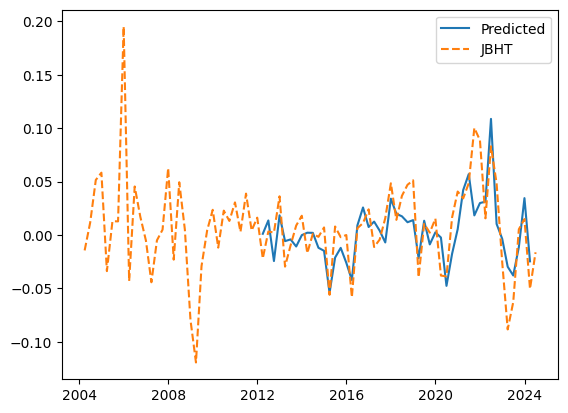

In [18]:
ticker = 'JBHT'
plt.plot(preds_dfs[0].index, preds_dfs[0][ticker], label='Predicted')
plt.plot(qtr_df.index, qtr_df[ticker], label=ticker, linestyle='--')
plt.legend()
plt.show()

In [19]:
preds_dfs[0].reset_index().rename(columns={'index':'date'}).to_csv('Sequential_Model_Preds.csv')